In [1]:
%cd "~/Projects/Segmentation/TreeSeg"
import json
import math
import os
from pathlib import Path

import json
import hashlib
import matplotlib.pyplot as plt
import networkx as nx
import nvdiffrast.torch as dr
import torch
from torch import Tensor, nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import yaml
from rich.console import Console
from rich.tree import Tree
import torch_geometric as pyg

import tree_segmentation.extension as ext
from tree_segmentation.extension import ops_3d, Mesh, utils
from tree_segmentation.render import render_mesh

/home/wan/Projects/Segmentation/TreeSeg
Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


2023-08-09 16:14:05.103473: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-09 16:14:06.881076: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/wan/miniconda3/envs/wan/lib/python3.8/site-packages/cv2/../../lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:/usr/local/cuda-11.7/lib64:
2023-08-09 16:14:06.881297: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared obje

In [2]:
print(torch.__version__)
%load_ext autoreload
%autoreload 2
%matplotlib inline

2.0.1+cu117


In [3]:
torch.set_grad_enabled(False)
console = Console()
device = torch.device("cuda")
# device = torch.device("cpu")
cache_root = Path('~/wan_code/segmentation/tree_segmentation/results').expanduser()
utils.set_printoptions(linewidth=120)
glctx = dr.RasterizeCudaContext()

In [4]:
data_root = Path('~/data/PartNet/data_v0').expanduser()
print(f"Data Root: {data_root}")
shapes = list(os.scandir(data_root))
print(f'There are {len(shapes)} shapes')

ShapeNet_root = Path('/data5/ShapeNet/ShapeNetCore.v1/')
print('ShapeNet root:', ShapeNet_root)

Data Root: /home/wan/data/PartNet/data_v0
There are 32537 shapes
ShapeNet root: /data5/ShapeNet/ShapeNetCore.v1


In [5]:
mesh_path = ShapeNet_root.joinpath('02818832/b1debacef4d43e4a20685b5a7e34b501/model.obj')
mesh = Mesh.load(mesh_path, mtl='keep')
mesh.check()
mesh.unit_size()
mesh.cuda()
print(mesh)

Mesh(vertices=10961, faces=45392, tex, f_mat, mat=['names', 'ka', 'kd', 'ks'])


In [6]:
last = None
num = 0
with open(mesh_path, 'r') as f:
    for line in f.readlines():
        items = line.split()
        if len(items)==0:
            continue
        if last == items[0]:
            num += 1
        else:
            print(last, num)
            last = items[0]
            num = 1

None 0
# 2
mtllib 1
o 1
v 1269
vt 3746
usemtl 1
s 1
f 39
s 1
f 50
usemtl 1
s 1
f 1410
s 1
f 1154
usemtl 1
s 1
f 528
s 1
f 1104
usemtl 1
s 1
f 819
usemtl 1
f 16
usemtl 1
f 4
o 1
v 134
usemtl 1
s 1
f 48
s 1
f 48
usemtl 1
s 1
f 80
s 1
f 388
o 1
v 134
usemtl 1
s 1
f 80
s 1
f 218
usemtl 1
f 170
usemtl 1
s 1
f 48
s 1
f 48
o 1
v 134
usemtl 1
s 1
f 80
s 1
f 218
usemtl 1
s 1
f 48
s 1
f 48
usemtl 1
f 170
o 1
v 248
usemtl 1
s 1
f 156
s 1
f 360
usemtl 1
f 224
usemtl 1
s 1
f 140
s 1
f 136
o 1
v 1224
vt 2167
usemtl 1
s 1
f 108
s 1
f 1088
usemtl 1
s 1
f 364
s 1
f 2168
usemtl 1
s 1
f 184
usemtl 1
s 1
f 1152
o 1
v 96
usemtl 1
s 1
f 96
s 1
f 96
usemtl 1
s 1
f 96
s 1
f 96
o 1
v 778
usemtl 1
s 1
f 548
s 1
f 268
usemtl 1
s 1
f 192
s 1
f 102
usemtl 1
f 48
usemtl 1
f 2160
o 1
v 49
usemtl 1
s 1
f 88
s 1
f 50
usemtl 1
f 50
o 1
v 51
usemtl 1
s 1
f 92
s 1
f 52
usemtl 1
f 52
o 1
v 48
usemtl 1
s 1
f 88
s 1
f 48
usemtl 1
f 48
o 1
v 48
usemtl 1
s 1
f 88
s 1
f 48
usemtl 1
f 48
o 1
v 966
usemtl 1
s 1
f 665
s 1
f 1452


In [16]:
num = 0
last = None
for i in range(len(mesh.f_mat)):
    if mesh.f_mat[i] == last:
        num += 1
    else:
        print(last, i-num, i)
        last = mesh.f_mat[i]
        num = 1
print(last, i-num, i)

None 0 0
tensor(0, device='cuda:0') 0 89
tensor(14, device='cuda:0') 89 2653
tensor(7, device='cuda:0') 2653 4285
tensor(8, device='cuda:0') 4285 5104
tensor(9, device='cuda:0') 5104 5120
tensor(10, device='cuda:0') 5120 5124
tensor(4, device='cuda:0') 5124 5220
tensor(6, device='cuda:0') 5220 5688
tensor(14, device='cuda:0') 5688 5986
tensor(3, device='cuda:0') 5986 6156
tensor(4, device='cuda:0') 6156 6252
tensor(14, device='cuda:0') 6252 6550
tensor(4, device='cuda:0') 6550 6646
tensor(5, device='cuda:0') 6646 6816
tensor(14, device='cuda:0') 6816 7332
tensor(3, device='cuda:0') 7332 7556
tensor(4, device='cuda:0') 7556 7832
tensor(0, device='cuda:0') 7832 9028
tensor(11, device='cuda:0') 9028 11560
tensor(12, device='cuda:0') 11560 11744
tensor(13, device='cuda:0') 11744 12896
tensor(14, device='cuda:0') 12896 13088
tensor(15, device='cuda:0') 13088 13280
tensor(14, device='cuda:0') 13280 14096
tensor(18, device='cuda:0') 14096 14390
tensor(1, device='cuda:0') 14390 14438
tensor(2,

In [13]:
image_size = 1024
fovy = math.radians(60)
num_views = 100
radius = torch.rand((num_views,), device=device) * 0.1 + 1.5
thetas = torch.arccos(torch.linspace(0, 1, num_views, device=device) * 2. - 1.)
phis = torch.linspace(0, 1, num_views, device=device) * 2.0 * torch.pi
# thetas = torch.tensor([90.], device=device).deg2rad_()
# phis = torch.ones((num,), device=device) * 0.5 * torch.pi
eye = ops_3d.coord_spherical_to(radius, thetas, phis).to(device)
Tw2v = ops_3d.look_at(eye, torch.zeros_like(eye))
Tv2c = ops_3d.perspective(fovy=fovy, size=(image_size, image_size), device=device)
Tw2c = Tv2c @ Tw2v

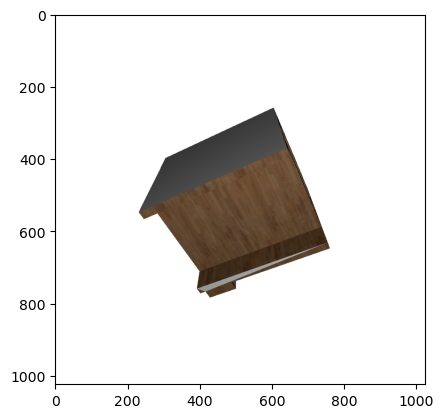

In [14]:
Tw2v = Tw2v[7:8]
image, tri_id = render_mesh(glctx, mesh, Tw2v, image_size=image_size)
plt.imshow(image[0].cpu().numpy())

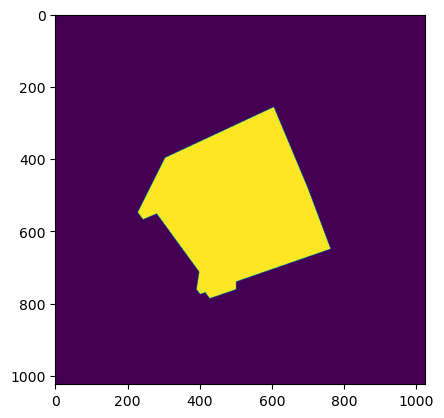

In [10]:
device = mesh.v_pos.device
camera_pos = Tw2v.inverse()[..., :3, 3]
if camera_pos.ndim == 1:
    camera_pos = camera_pos[None, None, None]
elif camera_pos.ndim == 2:
    camera_pos = camera_pos[:, None, None, :]
else:
    raise ValueError
view_direction = ops_3d.normalize(camera_pos)
lights = ops_3d.PointLight(
    ambient_color=utils.n_tuple(0.5, 3),
    diffuse_color=utils.n_tuple(1., 3),
    specular_color=utils.n_tuple(0.3, 3),
    device=device)
lights.location = camera_pos
# if Tw2c is None:
#     if Tw2v is not None:
Tv2c = ops_3d.perspective(fovy=fovy, size=(image_size, image_size), device=device)
Tw2c = Tv2c @ Tw2v
    # else:
    #     Tw2c = None
v_pos = mesh.v_pos.float() if Tw2c is None else ops_3d.xfm(mesh.v_pos.float(), Tw2c)
v_pos = v_pos[None] if v_pos.ndim == 2 else v_pos
rast, _ = dr.rasterize(glctx, v_pos, mesh.f_pos.int(), (image_size, image_size))
faces = rast[..., -1].int()
plt.imshow(faces[0].gt(0).cpu().numpy())

['material_0_1_8', 'material_10_24', 'material_11_24', 'material_12_24', 'material_13_24', 'material_14_24', 'material_15_24', 'material_16_2_8', 'material_17_3_8', 'material_18_4_8', 'material_19_24', 'material_1_24', 'material_2_24', 'material_3_24', 'material_4_24', 'material_5_24', 'material_6_24', 'material_7_24', 'material_8_24', 'material_9_24']
torch.Size([1, 1024, 1024, 2])


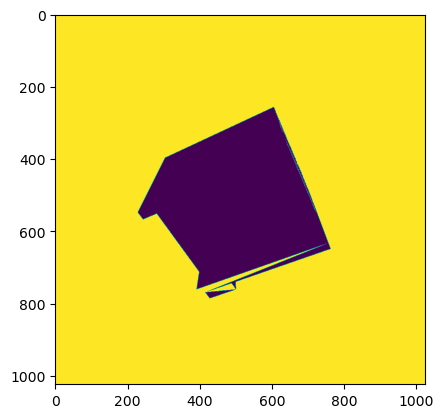

torch.Size([1, 1024, 1024]) tensor([ 0,  7,  8, 14], device='cuda:0')
faces: tensor([   0,   18,  397,  485,  509,  510,  549,  572,  609,  616,  631,  635,  678,  680,  691,  734,  740,  751,
         803,  881,  901,  971,  978,  982,  989, 1055, 1075, 1115, 1138, 1147, 1231, 1300, 1327, 1329, 1354, 1358,
        1464, 1487, 3411, 3436, 3484, 3505, 3608, 3612, 3638, 3680, 3690, 3719, 3751, 3752, 3766, 3773, 3774, 3791,
        3793, 3820, 3822, 3854, 3858, 3867, 3880, 3910, 3911, 3927, 3931, 3933, 3934, 3946, 3961, 3966, 3969, 3990,
        4007, 4027, 4028, 4037, 4038, 4039, 4040, 4055, 4060, 4062, 4076, 4093, 4094, 4103, 4113, 4133, 4160, 4164,
        4173, 4174, 4188, 4221, 4229, 4231, 4252, 4262, 4385, 4417, 4429, 4430, 4434, 4443, 4444, 4450, 4461, 4465,
        4485, 4486, 4487, 4489, 4492, 4510, 4511, 4512, 4513, 4515, 4516, 4517, 4518, 4519, 4520, 4536, 4539, 4541,
        4542, 4544, 4545, 4546, 4551, 4552, 4562, 4563, 4565, 4566, 4567, 4570, 4572, 4573, 4574, 4578, 4579, 4

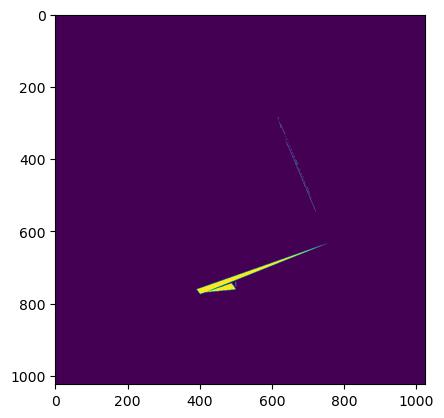

torch.Size([1, 1024, 1024, 3])


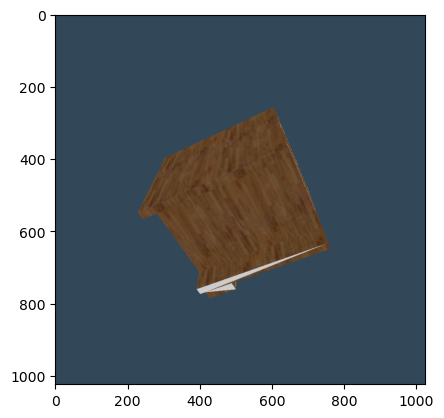

In [26]:
# if getattr(mesh, 'v_clr', None) is not None:
#     images, _ = dr.interpolate(mesh.v_clr[None, :, :].contiguous().float(), rast, mesh.f_pos.int())
# else:
perturbed_nrm = None
if mesh.f_tex is not None:
    print(mesh.material['names'])
    uv, uv_da = dr.interpolate(mesh.v_tex[None], rast, mesh.f_tex.int())
    print(uv.shape)
    plt.imshow(((4285 > faces)&(faces<=5104))[0].cpu().numpy())
    plt.show()
    if mesh.f_mat is not None:
        f_mat = torch.where(faces == 0, torch.zeros_like(faces), mesh.f_mat[faces - 1])
    else:
        f_mat = None
    print(f_mat.shape, torch.unique(f_mat))
    print('faces:', torch.unique(faces))
    # plt.imshow((f_mat[0]/len(mesh.material['kd'])).cpu().numpy())
    plt.imshow((f_mat[0]==14).cpu().numpy())
    plt.show()
    # f_mat.fill_(9)
    ka = mesh.material['ka'].sample(uv, f_mat=f_mat) if 'ka' in mesh.material else 0
    kd = mesh.material['kd'].sample(uv, f_mat=f_mat) if 'kd' in mesh.material else 0
    ks = mesh.material['ks'].sample(uv, f_mat=f_mat) if 'ks' in mesh.material else 0
    if 'normal' in mesh.material:
        perturbed_nrm = mesh.material['normal'].sample(uv, f_mat=f_mat)
else:
    assert False
    # ka = v_pos.new_full((3,), default_kads[0])
    # kd = v_pos.new_full((3,), default_kads[1])
    # ks = v_pos.new_full((3,), default_kads[2])
print(kd.shape)
plt.imshow(kd[0].cpu().numpy())

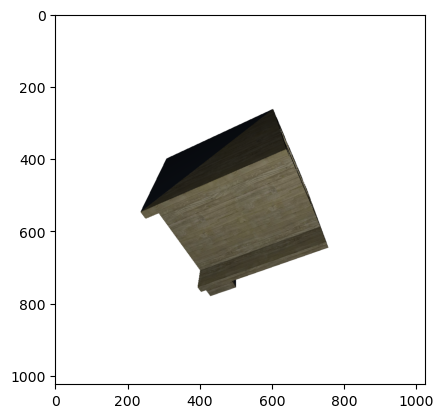

In [16]:
# if not use_face_normal and mesh.f_nrm is not None and mesh.f_tng is not None:
#         nrm = ops_3d.compute_shading_normal(mesh, camera_pos, rast, perturbed_nrm)
#     else:
nrm = ops_3d.compute_shading_normal_face(mesh, camera_pos, rast, None)
points, _ = dr.interpolate(mesh.v_pos[None].float(), rast, mesh.f_pos.int())
images = ops_3d.Blinn_Phong(nrm, lights(points), view_direction, (ka, kd, ks))
images = dr.antialias(images, rast, v_pos, mesh.f_pos.int()).clamp(0, 1)
images = torch.where(rast[..., -1:] > 0, images, torch.full_like(images, 1))
plt.imshow(images[0].cpu().numpy())

In [5]:
# example = data_root.joinpath('12136')
# example = data_root.joinpath('12012')
example = data_root.joinpath('7254')
# example = data_root.joinpath('22835')
# example = data_root.joinpath('27774')
print(f"Example dir", example)
with example.joinpath('meta.json').open('r') as f:
    meta = json.load(f)
print('meta:', meta)
# with example.joinpath('result_after_merging.json').open('r') as f:
#     meta_parts = json.load(f)
# print(list(os.scandir(example)))
# for item in os.scandir(example):
#     print('=' * 20, item.name, '=' * 20)
#     if item.name.endswith('.json'):
#         with example.joinpath(item.name).open('r') as f:
#             data = json.load(f)
#             print(yaml.dump(data))
mesh_path_shapenet = None
ShapeNet_shapes = []
for categroy in os.listdir(ShapeNet_root):
    if ShapeNet_root.joinpath(categroy, meta['model_id']).is_dir():
        mesh_path_shapenet = ShapeNet_root.joinpath(categroy, meta['model_id'])
        break
print(f"Find corresponding shape in ShapeNet:", mesh_path_shapenet)

Example dir /home/wan/data/PartNet/data_v0/7254
meta: {'model_id': '7cf2f3a1a3de48fda23949c21eddef76', 'anno_id': '7254', 'user_id': 'huangfuchong', 'time_in_sec': '257', 'version': '3', 'model_cat': 'Microwave'}
Find corresponding shape in ShapeNet: /data5/ShapeNet/ShapeNetCore.v2/03761084/7cf2f3a1a3de48fda23949c21eddef76


In [6]:
mesh = Mesh.load(mesh_path_shapenet.joinpath('models/model_normalized.obj'))
mesh.check()
mesh = mesh.unit_size().to(device)
# mesh.f_pos[:, -2:] = mesh.f_pos[:, -2:].flip(-1)
# mesh.f_tex[:, -2:] = mesh.f_tex[:, -2:]d.flip(-1)
# mesh.f_nrm[:, -2:] = mesh.f_nrm[:, -2:].flip(-1)
mesh.compuate_normals_(force=False)
f_pos = mesh.f_pos
f_nrm = mesh.f_nrm
f_tex = mesh.f_tex

image_size = 512
fovy = math.radians(90)
glctx = dr.RasterizeCudaContext()


In [7]:
num_views = 10
torch.manual_seed(42)
radius = torch.rand((num_views,), device=device) * 0.1 + 2.5
thetas = torch.arccos(torch.linspace(0, 1, num_views, device=device) * 2. - 1.)
phis = torch.linspace(0, 1, num_views, device=device) * 2.0 * torch.pi
# thetas = torch.tensor([90.], device=device).deg2rad_()
# phis = torch.ones((num,), device=device) * 0.5 * torch.pi
eye = ops_3d.coord_spherical_to(radius, thetas, phis).to(device)
Tw2v = ops_3d.look_at(eye, torch.zeros_like(eye))
Tv2c = ops_3d.perspective(fovy=fovy, size=(image_size, image_size), device=device)
Tw2c = Tv2c @ Tw2v

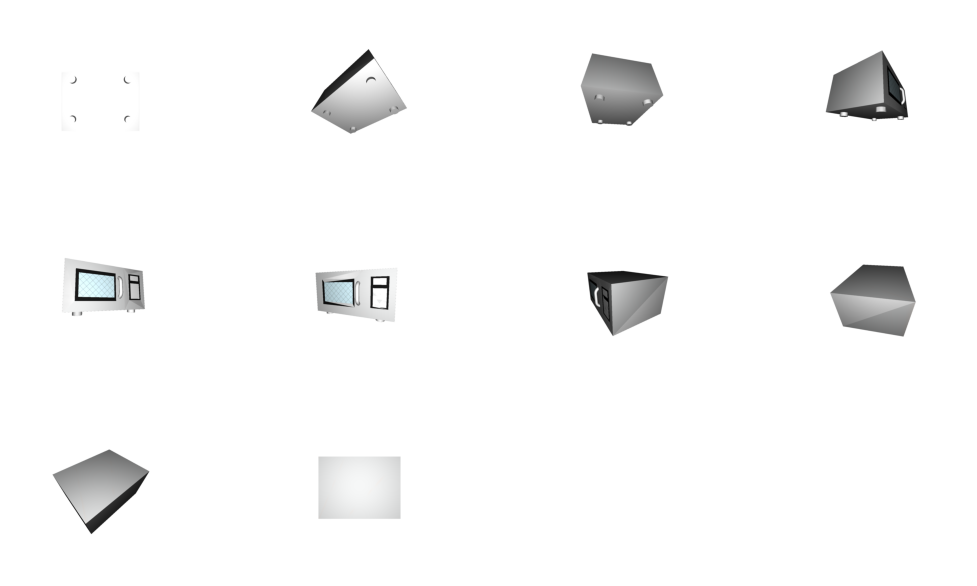

In [8]:
# mesh.compuate_normals_(force=True)
mesh.f_tex = f_tex.clone()
mesh.f_pos = f_pos.clone()
mesh.f_nrm = f_nrm.clone()
for index in [ 14766, 14767, 14771, 14773]:
    index= index -1
    # mesh.f_tex[index] = mesh.f_tex[index].flip(-1)
    mesh.f_pos[index] = mesh.f_pos[index].flip(-1)
    # mesh.f_nrm[index] = mesh.f_nrm[index].flip(-1)
mesh.compute_tangents_(force=True)
images, tri_ids = render_mesh(glctx, mesh, Tw2v, Tw2c, fovy)
plt.figure(dpi=200)
for i in range(min(16, images.shape[0])):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].cpu().numpy())
    plt.axis('off')

In [9]:
print(torch.unique(tri_ids[9]))

tensor([    0, 14766, 14767, 14771, 14773], device='cuda:0', dtype=torch.int32)


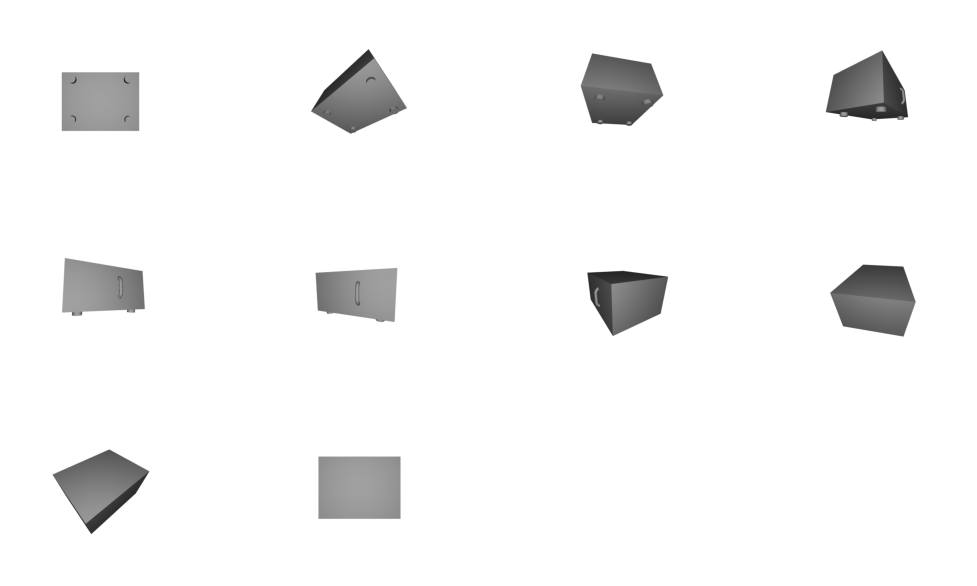

In [10]:
# mesh.compuate_normals_(force=True)
mesh = Mesh.load(mesh_path_shapenet.joinpath('models/model_normalized.obj'))
mesh.check()
mesh = mesh.unit_size().to(device)
mesh.f_pos[:, -2:] = mesh.f_pos[:, -2:].flip(-1)
mesh.f_tex[:, -2:] = mesh.f_tex[:, -2:].flip(-1)
mesh.f_nrm[:, -2:] = mesh.f_nrm[:, -2:].flip(-1)
mesh.compute_tangents_()
mesh.f_tex = None
images, tri_ids = render_mesh(glctx, mesh, Tw2v, Tw2c, fovy)
plt.figure(dpi=200)
for i in range(min(16, images.shape[0])):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].cpu().numpy())
    plt.axis('off')

In [11]:
mesh.f_tex = f_tex.clone()
mesh.f_pos = f_pos.clone()
mesh.f_nrm = f_nrm.clone()

v_pos = mesh.v_pos.float() if Tw2c is None else ops_3d.xfm(mesh.v_pos.float(), Tw2c)
v_pos = v_pos[None] if v_pos.ndim == 2 else v_pos
rast, _ = dr.rasterize(glctx, v_pos, mesh.f_pos.int(), (image_size, image_size))

unchanged = torch.ones(len(mesh.f_pos), dtype=torch.bool, device=device)
for i in range(num_views):
    f_indices = torch.unique(rast[i, :, :, -1].int())
    if f_indices[0] == 0:
        f_indices = f_indices[1:]
    f_indices = f_indices - 1
    f_indices = f_indices[unchanged[f_indices]]
    if len(f_indices) == 0:
        continue
    unchanged[f_indices] = 0
    v0, v1, v2 = v_pos[i, mesh.f_pos[f_indices], :3].unbind(1)
    face_normals = torch.cross(v1 - v0, v2 - v0)
    f_indices = f_indices[face_normals[:, -1] < 0]  # need change faces
    if len(f_indices) == 0:
        continue
    print(len(f_indices))
    mesh.f_pos[f_indices, :] = mesh.f_pos[f_indices, :].flip(-1)
    mesh.f_tex[f_indices, :] = mesh.f_tex[f_indices, :].flip(-1)
    mesh.f_nrm[f_indices, :] = mesh.f_nrm[f_indices, :].flip(-1)
    # mesh.f_tng[f_indices, :] = mesh.f_tng[f_indices, :].flip(-1)

217
49
20
260
125
111
87
3


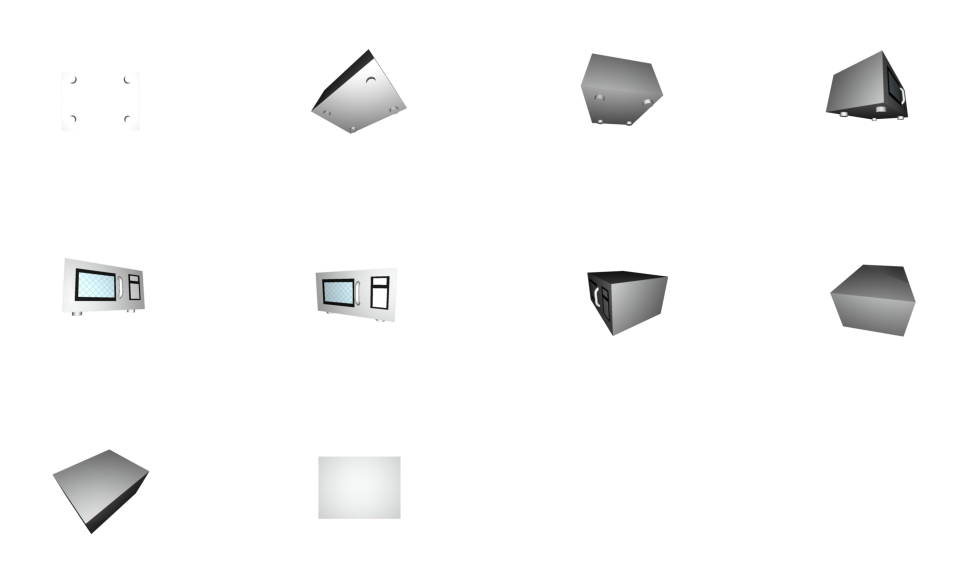

In [12]:
# mesh.compuate_normals_(force=True)
mesh.compute_tangents_(force=True)
images, tri_ids = render_mesh(glctx, mesh, Tw2v, Tw2c, fovy)
plt.figure(dpi=200)
for i in range(min(16, images.shape[0])):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].cpu().numpy())
    plt.axis('off')

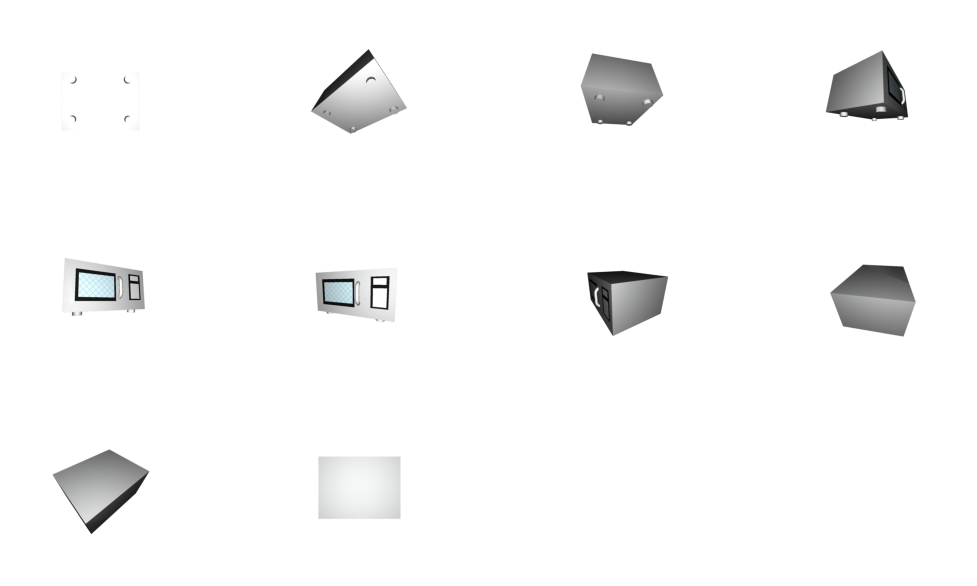

In [13]:
# mesh.compuate_normals_(force=True)
mesh.compute_tangents_(force=True)
images, tri_ids = render_mesh(glctx, mesh, Tw2v, Tw2c, fovy)
plt.figure(dpi=200)
for i in range(min(16, images.shape[0])):
    plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].cpu().numpy())
    plt.axis('off')